https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import math
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
np.random.seed(7)

Using TensorFlow backend.


### Data Paths

In [2]:
data_path = '~/Desktop/kaggle/Grocery/data/'
Holiday_Events = pd.read_csv(data_path + 'holidays_events.csv')
Items = pd.read_csv(data_path + 'items.csv')
Oil = pd.read_csv(data_path + 'oil.csv')
Sample_Submission = pd.read_csv(data_path + 'sample_submission.csv')
Stores = pd.read_csv(data_path + 'stores.csv')
Test = pd.read_csv(data_path + 'test.csv')
Transactions = pd.read_csv(data_path + 'transactions.csv')

### Data Prep Helper Functions

In [78]:
#Data Prep functions
def prep_data(dataset):
    #Perform initial data transformations
    
    start_dt = '1/2/2013'
    end_dt = '8/15/2017'
    
    
    
    
    
    dataset = dataset[['date','store_nbr','unit_sales','onpromotion']]
    dt_rng = pd.date_range(start = start_dt, end = end_dt, freq='D')
    day = pd.DataFrame({'day': dt_rng.dayofweek})
    dt_rng = pd.to_datetime(dt_rng)
    dt_rng = pd.DataFrame({'date': dt_rng.strftime('%Y-%m-%d'),
                          'day': dt_rng.dayofweek})
    time_step = pd.Series(range(1,len(dt_rng)+1))
    time_step_map = pd.DataFrame({'date': dt_rng['date'],
                                 'time_step': time_step,
                                 'day': dt_rng['day']})
    stores = pd.DataFrame({'store_nbr':pd.Series(range(1,54))})
    dataset_calendar = cartesian_product(dt_rng, stores)
    dataset = pd.merge(dataset_calendar, dataset, how = 'left', on=['date','store_nbr'])
    #impute
    #Set weekends to 0
    dataset.loc[(dataset['day']==5) | (dataset['day']==6),'unit_sales'] = 0
    dataset.loc[(dataset['day']==5) | (dataset['day']==6),'onpromotion'] = False
    
    #Set unknown promitions to 'False'
    dataset.loc[pd.isnull(dataset['onpromotion']),'onpromotion'] = False
    #Add lags
    dataset = pd.merge(dataset, time_step_map, how = 'left', on = ['date'])
    print(dataset.columns)
    day = dataset.loc[:,['day_x','time_step']]
    dataset = dataset.drop(['date', 'day_y','day_x'],axis=1)
    #Column-wise adjustments:
    dataset['onpromotion'] = dataset['onpromotion'].astype(int)
    
    
    
    #generalize:
    #get list of columns to be pivoted
    column_set = [c for c in dataset.columns if c not in ['time_step', 'store_nbr']]
    #create pivoted tables
    table_list = []
    for c in column_set:
        tmp = pd.DataFrame(dataset.pivot(index = 'time_step', columns = 'store_nbr', values = c).to_records())
        
        new_cols = []
        for i in range(1,54):
            new_cols.append(c + '_' + str(i))
        new_cols.insert(0, 'time_step')
        tmp.columns = new_cols
        table_list.append(tmp)
        
    tst = pd.merge(table_list[0], table_list[1], how = 'inner', on = ['time_step'])
    final = table_list[0]
    for i in range(1, len(table_list)):
        final = pd.merge(final, table_list[i], how = 'inner', on = 'time_step')
    
    final = pd.merge(final, time_step_map, how = 'inner', on = 'time_step')
    final = final.drop(['date'],axis = 1)
    return(final)

def cartesian_product(A,B):
    A['key'] = 0
    B['key'] = 0
    C = A.merge(B, how ='left', on = 'key')
    C.drop('key', 1, inplace = True)
    return(C)
    
def create_dataset(dataset, look_back=1, target_Col = 1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, target_Col])
    return np.array(dataX), np.array(dataY)

def invert_predictions(preds, iShape, aScaler):
    #preds set of predictions
    #iShape shape tuple used in normalization
    #aScaler scaling object
    struct = np.zeros(iShape)
    #print(preds.shape)
    struct[0:len(preds),0] = preds[:,0]
    #print(struct.shape)
    struct = aScaler.inverse_transform(struct)
    inverted_preds = struct[0:len(preds),0]
    return inverted_preds


def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    cols = dataset.shape[1]
    for i in range(len(dataset)-look_back):
        tmp=[]
        for j in range(cols):
            tmp = np.concatenate((tmp,dataset[i:(i+look_back),j]),axis=0)
        dataX.append(tmp)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [69]:
#Get all records on this item
Item=108831
reader = pd.read_csv(data_path +  'train.csv', chunksize=100000)
dataset = pd.concat(chunk[chunk['item_nbr']==Item] for chunk in reader)
dataset = prep_data(dataset)
dataset.head()

Index([u'date', u'day_x', u'store_nbr', u'unit_sales', u'onpromotion',
       u'day_y', u'time_step'],
      dtype='object')


,time_step,unit_sales_1,unit_sales_2,unit_sales_3,unit_sales_4,unit_sales_5,unit_sales_6,unit_sales_7,unit_sales_8,unit_sales_9,...,onpromotion_45,onpromotion_46,onpromotion_47,onpromotion_48,onpromotion_49,onpromotion_50,onpromotion_51,onpromotion_52,onpromotion_53,day
0,1,35.512,45.794,135.003,35.341,5.094,55.285,63.056,124.253,NaN,...,0,0,0,0,0,0,0,0,0,2
1,2,35.574,NaN,143.879,18.032,22.203,41.612,28.806,68.900,NaN,...,0,0,0,0,0,0,0,0,0,3
2,3,4.371,11.724,125.306,12.888,16.638,18.312,6.562,83.894,NaN,...,0,0,0,0,0,0,0,0,0,4
3,4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,...,0,0,0,0,0,0,0,0,0,5
4,5,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,...,0,0,0,0,0,0,0,0,0,6


In [81]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [10]:
#Train/Test split:
train_len = int(0.67 * len(dataset))
test_size = len(dataset) - train_len
train, test = dataset[0:train_len,:], dataset[train_len:len(dataset),:]

In [11]:
trainX, trainY = create_dataset(train, 30)
testX, testY = create_dataset(test,30)

In [22]:
dataset = dataset_backup
dataset= dataset.values
tx, ty = create_dataset(dataset,30)

In [12]:
trainX.shape

(59874, 30, 4)

In [15]:
trainX[0,:,:]

array([[ 0.03895056,  0.33333334,  0.        ,  0.        ],
       [ 0.04898437,  0.33333334,  0.01923077,  0.        ],
       [ 0.13604006,  0.33333334,  0.03846154,  0.        ],
       [ 0.03878368,  0.33333334,  0.05769231,  0.        ],
       [ 0.00926679,  0.33333334,  0.07692308,  0.        ],
       [ 0.05824628,  0.33333334,  0.09615386,  0.        ],
       [ 0.0658297 ,  0.33333334,  0.11538462,  0.        ],
       [ 0.12554954,  0.33333334,  0.13461539,  0.        ],
       [ 0.00331988,  0.33333334,  0.15384616,  0.        ],
       [ 0.00331988,  0.33333334,  0.17307693,  0.        ],
       [ 0.00331988,  0.33333334,  0.1923077 ,  0.        ],
       [ 0.00331988,  0.33333334,  0.21153848,  0.        ],
       [ 0.00331988,  0.33333334,  0.23076923,  0.        ],
       [ 0.00331988,  0.33333334,  0.25      ,  0.        ],
       [ 0.00331988,  0.33333334,  0.26923075,  0.        ],
       [ 0.00331988,  0.33333334,  0.28846154,  0.        ],
       [ 0.00331988,  0.

###Model

In [51]:
model = Sequential()
model.add(LSTM(20, input_shape=(30,4)))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.fit(trainX, trainY, epochs = 20, batch_size=1, verbose = 1)

Epoch 1/20
 4547/59874 [=>............................] - ETA: 12:05 - loss: 2.8756e-04

KeyboardInterrupt: 

In [47]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


trainPredict = invert_predictions(trainPredict, shape_tuple, scaler)
testPredict = invert_predictions(testPredict, shape_tuple, scaler)

In [48]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 12.05 RMSE
Test Score: 3.71 RMSE


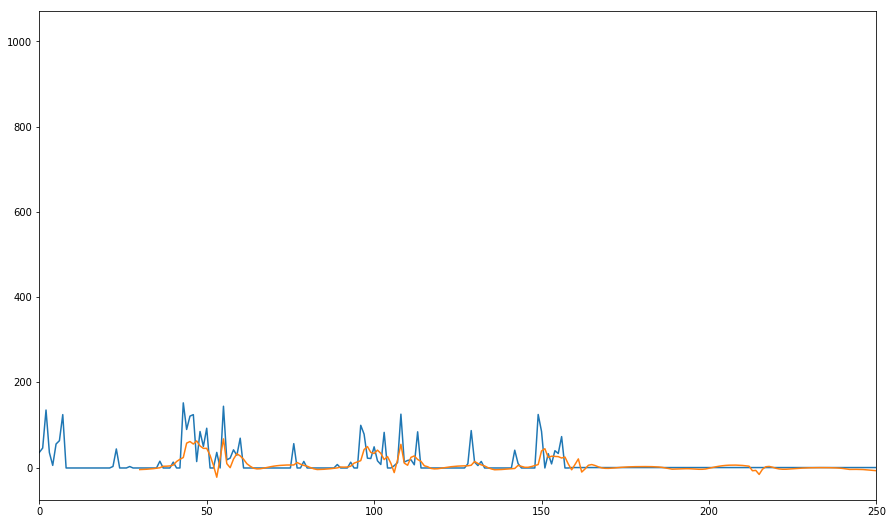

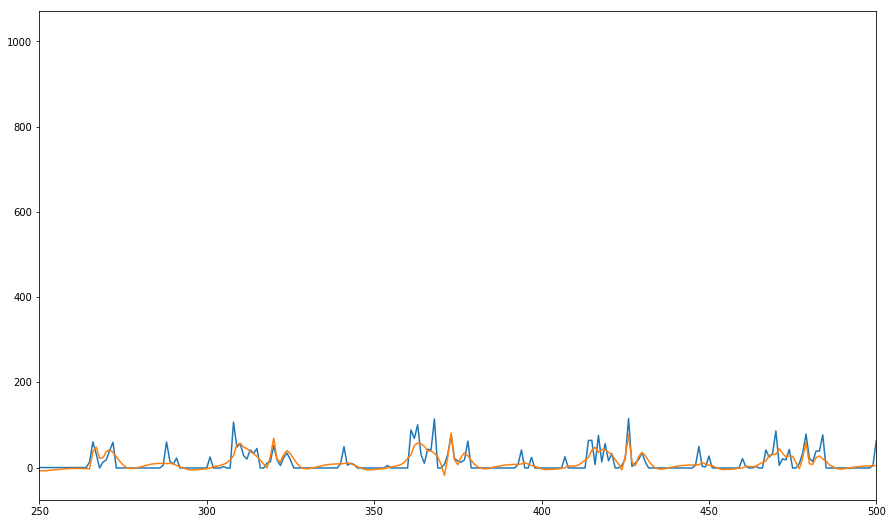

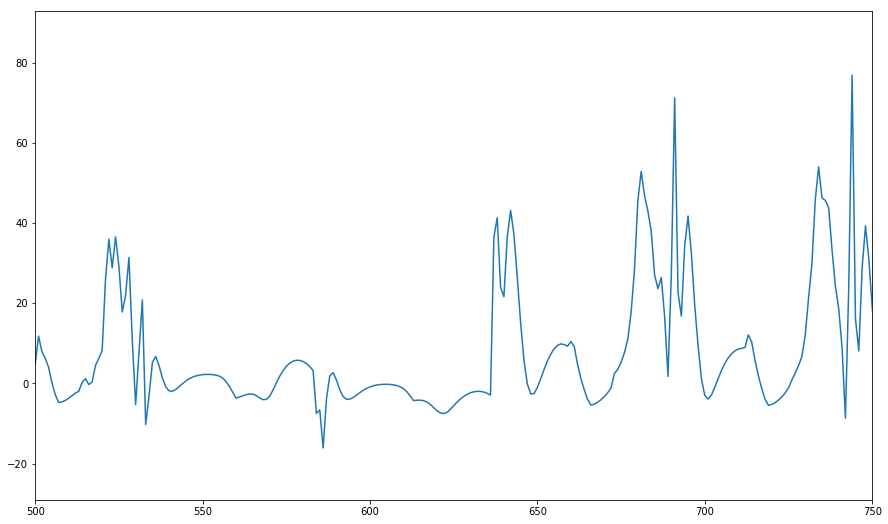

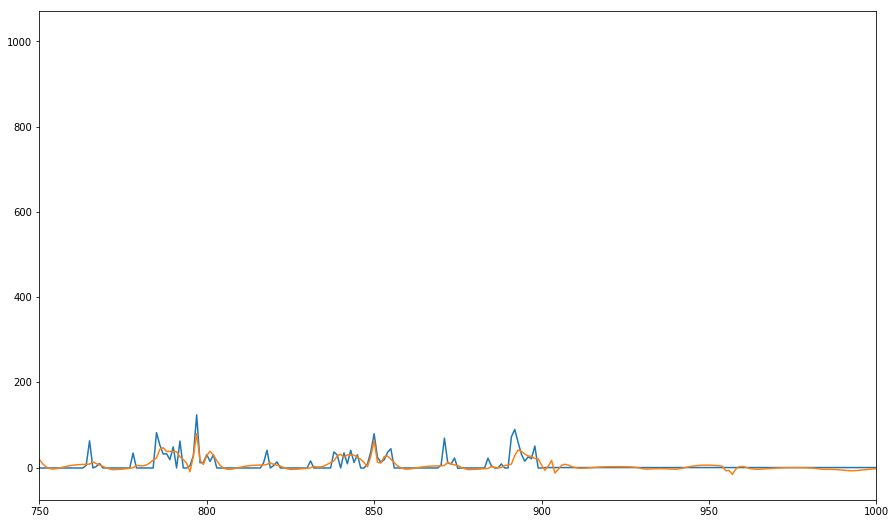

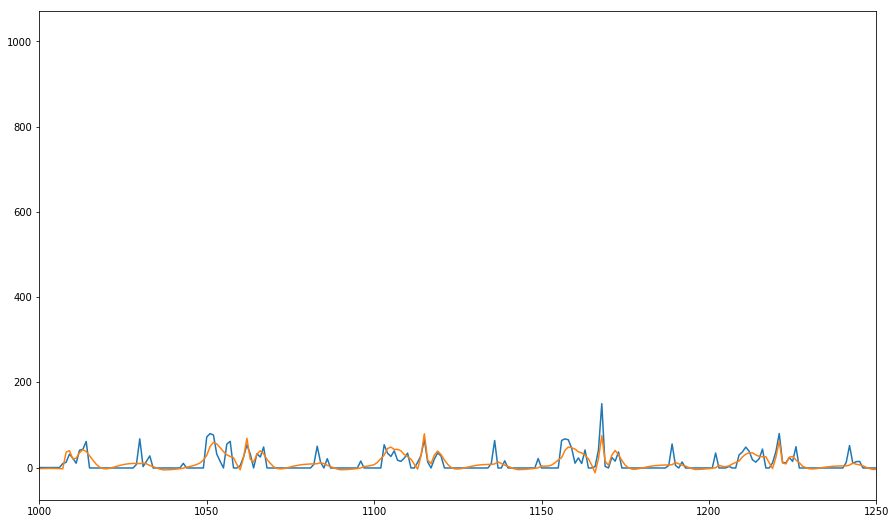

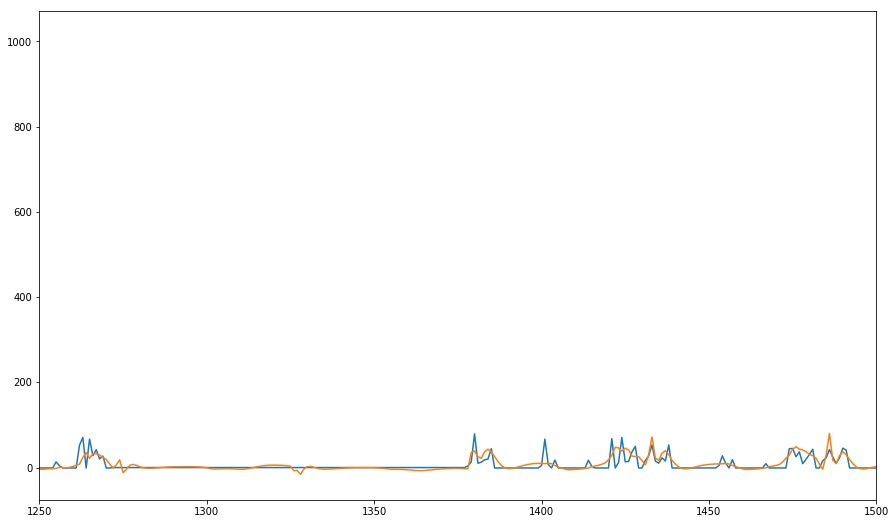

In [49]:
look_back = 30
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, 0] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, 0] = testPredict
# plot baseline and predictions

plt.rcParams["figure.figsize"] = (15,9)
plt.plot(dataset_backup.loc[:,['unit_sales']].values)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.xlim(0,250)
plt.show()
plt.plot(dataset_backup.loc[:,['unit_sales']].values)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.xlim(250,500)
plt.show()
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.xlim(500,750)
plt.show()

plt.plot(dataset_backup.loc[:,['unit_sales']].values)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.xlim(750,1000)
plt.show()
plt.plot(dataset_backup.loc[:,['unit_sales']].values)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.xlim(1000,1250)
plt.show()
plt.plot(dataset_backup.loc[:,['unit_sales']].values)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.xlim(1250,1500)
fig = plt.figure(figsize=(50, 16))
plt.show()